***

<div style="text-align: center"><font size="6" color='red'><b>Half Face - Optimizer: Adam, Epoch: 60, Learning Rate: 0.001</b> </font></div>

***

<font size="6"><b>Importing All Necessary Libraries</b> </font>

***

***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation 
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

<font size="6"><b>Importing Dataset</b> </font>

***

In [2]:
# Original Dataset
e = pd.read_csv(r"C:/fer2013HalfImage.csv")
e.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


***

<font size="6"><b>Data Exploration</b> </font>

***

## Number of Rows and Columns

In [3]:
e.shape

(35887, 3)

## Distribution of Training, Validation, and Testing Set

In [4]:
e.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Count of Each Emotion in Dataset

C:\Users\sarr6790\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


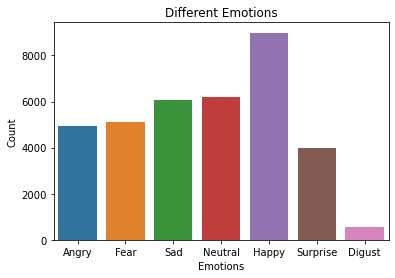

In [5]:
e_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
e_count = e['emotion'].value_counts(sort=False).reset_index()
e_count.columns = ['emotion', 'counts']
e_count['emotion'] = e_count['emotion'].map(e_map)

sns.barplot(e_count.emotion, e_count.counts)
plt.title('Different Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

## Each Column in Dataset Contain Picture

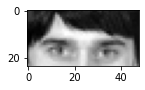

In [6]:
one = e.loc[32222]
pix = one["pixels"]
b = bytes(int(p) for p in pix.split())

i = Image.frombuffer('L', (48, 24), b)

plt.figure(figsize=(2, 2))
plt.gray()
plt.imshow(i)
plt.show()

***

<font size="6"><b>Data Preparation</b> </font>

***

## Dividing Training, Validation, and Testing Set

In [7]:
e_train = e[e['Usage']=='Training'].copy()
e_validation = e[e['Usage']=='PublicTest'].copy()
e_test  = e[e['Usage']=='PrivateTest'].copy()

N_train, _ = e_train.shape
N_validation, _ = e_validation.shape
N_test, _ = e_test.shape

## Preparing Training, Validation, and Testing Set

In [8]:
def DataPrepare(e, N):
    e['pixels'] = e['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    X = np.array(e['pixels'].tolist(), dtype='float32').reshape(N, 48, 24, 1)/255.0
    Y = to_categorical(e['emotion'], 7)  
    return X, Y

X_train, Y_train = DataPrepare(e_train, N_train) #training data
X_validation, Y_validation = DataPrepare(e_validation, N_validation) #validation data
X_test, Y_test = DataPrepare(e_test, N_test) #test data

***

<font size="6"><b>Convolutional Neural Network (CNN) Model</b> </font>

***

In [9]:
e_model = Sequential()

# Module 1
e_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,24,1)))
e_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.25))

# Module 2
e_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))

# Module 3
e_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.25))

# Flatten
e_model.add(Flatten())

# Dense
e_model.add(Dense(1024, activation='relu'))
e_model.add(Dropout(0.5))

# Output Layer
e_model.add(Dense(7, activation='softmax'))

e_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 22, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 20, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 10, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 8, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 4, 128)       0         
 2D)                                                    

## Fitting Training and Validation Set in CNN Model

In [10]:
learningrate = 0.001
epoch = 60

In [11]:
e_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate = learningrate, decay = 1e-6),metrics=['accuracy'])
path_model='model_half.h5' # save model at this location after each epoch
K.clear_session() # destroys the current graph and builds a new one
# fit the model
history = e_model.fit(x=X_train,     
            y=Y_train, 
            batch_size=64, 
            epochs=epoch, 
            verbose=1, 
            validation_data=(X_validation,Y_validation),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/60
449/449 [==============================] - 66s 145ms/step - loss: 1.8097 - accuracy: 0.2480 - val_loss: 1.7855 - val_accuracy: 0.2510
Epoch 2/60
449/449 [==============================] - 62s 138ms/step - loss: 1.7678 - accuracy: 0.2676 - val_loss: 1.7438 - val_accuracy: 0.2795
Epoch 3/60
449/449 [==============================] - 61s 135ms/step - loss: 1.7185 - accuracy: 0.2996 - val_loss: 1.6947 - val_accuracy: 0.3054
Epoch 4/60
449/449 [==============================] - 61s 135ms/step - loss: 1.6822 - accuracy: 0.3169 - val_loss: 1.6655 - val_accuracy: 0.3149
Epoch 5/60
449/449 [==============================] - 61s 137ms/step - loss: 1.6519 - accuracy: 0.3334 - val_loss: 1.6136 - val_accuracy: 0.3500
Epoch 6/60
449/449 [==============================] - 61s 137ms/step - loss: 1.6184 - accuracy: 0.3508 - val_loss: 1.5971 - val_accuracy: 0.3636
Epoch 7/60
449/449 [==============================] - 61s 136ms/step - loss: 1.5921 - accuracy: 0.3662 - val_loss: 1.5811 - val_ac

In [12]:
e = history.epoch
acc = history.history['accuracy']
valacc = history.history['val_accuracy']
loss = history.history['loss']
valloss = history.history['val_loss']

In [13]:
e_model.save('model_half.h5')

In [14]:
e_model = load_model('model_half.h5')

***

<font size="6"><b>Accuracy of Model on Training and Validation Set</b> </font>

***

C:\Users\sarr6790\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sarr6790\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sarr6790\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sarr

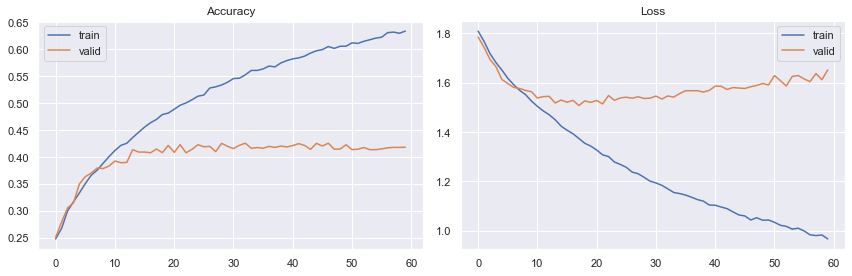

In [15]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(e, acc, label='train')
sns.lineplot(e, valacc, label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(e, loss, label='train')
sns.lineplot(e, valloss, label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

***

<font size="6"><b>Accuracy of Model on Testing Set</b> </font>

***

In [16]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(e_model.predict(X_test), axis=1)
print("CNN Model Accuracy on testing set: {:.4f}".format(accuracy_score(test_true, test_pred)))

print('\nClassification Report:')
print(classification_report(test_true, test_pred))

print('Confusion Matrix:')
print(confusion_matrix(test_true, test_pred))

CNN Model Accuracy on testing set: 0.4319

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.22      0.29       491
           1       0.61      0.35      0.44        55
           2       0.40      0.22      0.28       528
           3       0.44      0.63      0.51       879
           4       0.34      0.38      0.35       594
           5       0.66      0.60      0.63       416
           6       0.40      0.46      0.43       626

    accuracy                           0.43      3589
   macro avg       0.47      0.41      0.42      3589
weighted avg       0.43      0.43      0.42      3589

Confusion Matrix:
[[108   2  31 141 112  16  81]
 [  5  19   6  16   4   2   3]
 [ 31   2 114 124 128  55  74]
 [ 37   2  35 550  98  31 126]
 [ 43   2  40 173 223   7 106]
 [  7   1  37  65  23 250  33]
 [ 23   3  25 193  77  19 286]]


***

<font size="6"><b>Detecting Emotion Using Full Face</b> </font>

***

In [17]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
    
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

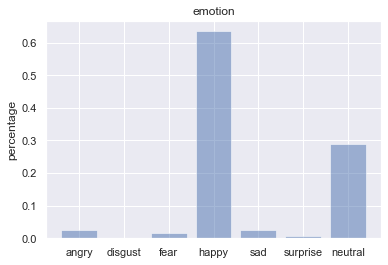

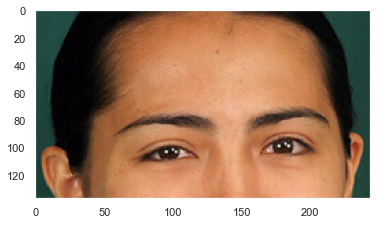

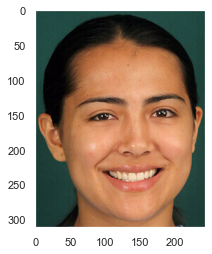

Expression Prediction:  Happy


In [18]:
file = r"C:\images\happy1half.png"
file1 = r"C:\images\happy1.png"
true_image = image.load_img(file)
full_image = image.load_img(file1)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 24))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = e_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 24]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
plt.grid(False)
plt.imshow(full_image)
plt.show()        

print('Expression Prediction: ', label_map[ind])

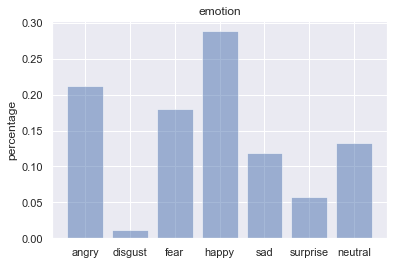

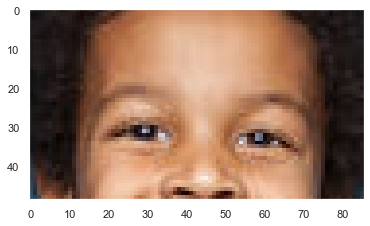

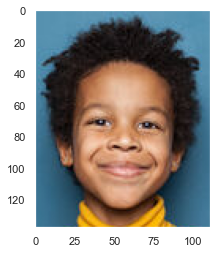

Expression Prediction:  Happy


In [25]:
file = r"C:\images\happy5half.png"
file1 = r"C:\images\happy5.png"
true_image = image.load_img(file)
full_image = image.load_img(file1)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 24))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = e_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 24]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
plt.grid(False)
plt.imshow(full_image)
plt.show()        

print('Expression Prediction: ', label_map[ind])